In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
from tqdm import tqdm_notebook as tqdm

batch_size = 32

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# GAN helpers

In [2]:
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y
    
def show_generated_img_all(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG(noise, dog_label).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()
        
# def show_generated_img():
#     noise = torch.randn(1, nz, 1, 1, device=device)
#     gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
#     gen_image = gen_image.numpy().transpose(1, 2, 0)
#     gen_image = ((gen_image+1.0)/2.0)
#     plt.imshow(gen_image)
#     plt.show()  
    
# def show_generated_img(n_images=5, nz=128):
#     sample = []
#     for _ in range(n_images):
#         noise = torch.randn(1, nz, 1, 1, device=device)
#         dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
#         gen_image = netG(noise, dog_label).to("cpu").clone().detach().squeeze(0)
#         gen_image = gen_image.numpy().transpose(1, 2, 0)
#         sample.append(gen_image)
        
#     figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
#     for index, axis in enumerate(axes):
#         axis.axis('off')
#         image_array = (sample[index] + 1.) / 2.
#         axis.imshow(image_array)
#     plt.show()    
    
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super(MinibatchStdDev, self).__init__()
    def forward(self, x, alpha=1e-8):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size,1, height, width)
        y = torch.cat([x, y], 1)
        return y    
    
    
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))  

def sndeconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
    return spectral_norm(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))  

def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

class ConditionalBatchNorm2d(nn.Module):
    # https://github.com/pytorch/pytorch/issues/8985#issuecomment-405080775
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, momentum=0.001, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        # self.embed.weight.data[:, :num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()  # Initialize bias at 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
        
    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
#         x= self.conv5(x)
        return x.view(-1, 1)

# Data loader

In [4]:
from load_data import DataGenerator, show_img

In [5]:
database = 'data/'
batch_size = 32
# N = 25000
N = 250

random_transforms = [transforms.RandomRotation(degrees=5)]

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=N)

train_loader = DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size, num_workers=4)

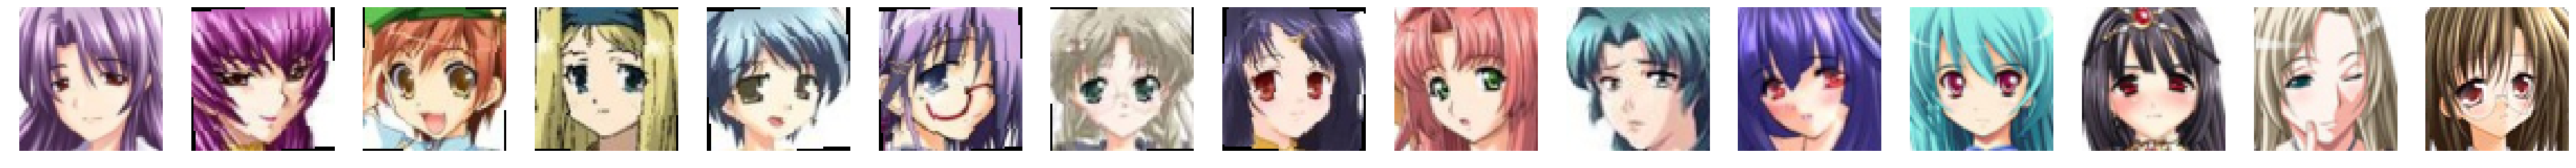

In [6]:
for i, batch in enumerate(train_loader):
    show_img(batch, 15)
    break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0005
lr_d = 0.0003
beta1 = 0.5
epochs = 1000
netG = Generator(128, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()
criterionH = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999))
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=epochs//200, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=epochs//200, eta_min=0.00005)

nz = 128
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.7
fake_label = 0.0
batch_size = train_loader.batch_size

def get_model_weights(net):
    average = {}
    params = dict(net.named_parameters())
    for p in params:
        average[p] = params[p].detach()    
    return average    

In [8]:
averageD = False
averageG = False
hist_average_cutoff = 400

In [9]:
def show_generated_img(n_images=10, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()


                    [1/1000][780/781] 
                    Loss_D: 1.0528 Loss_G: 2.9187 
                    D(x): 0.5740 | D(G(z)): 0.2713 / 0.0166
            


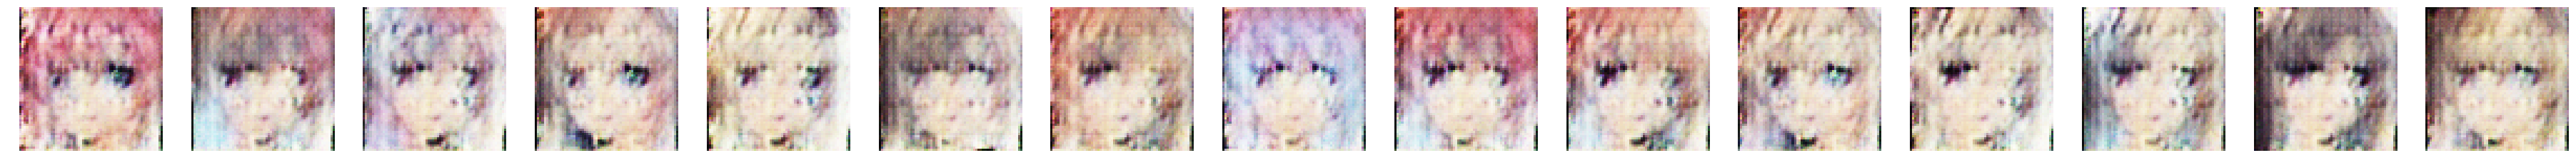

KeyboardInterrupt: 

In [10]:
step = 1
for epoch in tqdm(range(epochs)):
    for ii, (real_images) in enumerate(train_loader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Historical averaging weights
        err_hD = 0
        if epoch > hist_average_cutoff:
            if not averageD:
                print("Starting historical weight averaging for discriminator")
                averageD = get_model_weights(netD)
            paramsD = dict(netD.named_parameters())
            for p in paramsD:
                err_hD += criterionH(paramsD[p], averageD[p])
                averageD[p] = (averageD[p] * (step-1) + paramsD[p].detach())/step
            err_hD.backward()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label) + np.random.uniform(0, 0.2)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD_final = errD_real + errD_fake + err_hD
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################   
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
                
        err_hG = 0
        if epoch > hist_average_cutoff:
            if not averageG:
                print("Starting historical weight averaging for generator")
                averageG = get_model_weights(netG)
            paramsG = dict(netG.named_parameters())
            for p in paramsG:
                err_hG += criterionH(paramsG[p], averageG[p])
                averageG[p] = (averageG[p] * (step-1) + paramsG[p].detach())/step
            err_hG.backward()
            step += 1
        
        errG_final = errG + err_hG
        optimizerG.step()
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
    if epoch % 10 == 0:
        info = f"""
                    [{epoch+1}/{epochs}][{ii}/{len(train_loader)}] 
                    Loss_D: {errD_final.item():.4f} Loss_G: {errG_final.item():.4f} 
                    D(x): {D_x:.4f} | D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}
            """
        print(info)
        show_generated_img(15)